In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import e
from joblib import dump, load
import statistics as st
from calendar import isleap

# ERA5 Historical

In [2]:
#Surface data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
# 850 Data
tuv850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')

# Read Orography
OroData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')

t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86)).t2m
OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))
tuv850D = tuv850Data.sel(latitude=slice(32,24),longitude=slice(74,86)).t

# create mask
oro = OroD.z
oro.values = OroD.z.values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3127: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


<xarray.DataArray 'rh' (dayofyear: 63)>
array([-3.8181508, -3.6750824, -3.4052045, -3.2903903, -3.1604106,
       -3.540995 , -3.7675114, -3.9418492, -4.0019326, -3.9184082,
       -4.0350237, -4.1161766, -4.219451 , -3.946696 , -3.9969985,
       -4.109483 , -3.8883672, -4.0009804, -4.0574746, -4.0816755,
       -4.2107496, -4.312479 , -4.5698094, -4.3709917, -4.379168 ,
       -4.5246606, -4.7272553, -4.9847503, -5.0308723, -5.0603485,
       -5.2926292, -4.2335205, -4.34865  , -4.232645 , -3.9181905,
       -3.6047094, -3.7914083, -3.7703953, -3.8914459, -4.0031595,
       -4.154578 , -4.039496 , -3.9385662, -3.7312105, -3.5705185,
       -3.3840392, -3.360157 , -3.3892066, -3.5318604, -3.5780733,
       -3.483313 , -3.1506512, -3.2052941, -3.5215197, -3.8000515,
       -3.808461 , -3.9285579, -3.9410992, -3.863624 , -3.7243664,
       -3.7229974, -3.7243876, -3.3672712], dtype=float32)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366


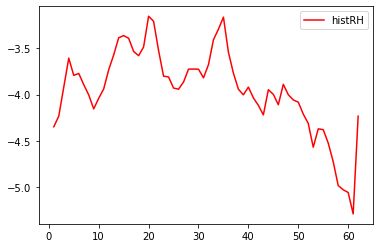

In [3]:

#Calculate inv
inv=tuv850D.values-t2mD.values
rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), inv)}, coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
rh_ds.attrs
rh_ds.attrs['units']='K'
rh_ds.attrs['long_name']='t850 - t2m'


# apply mask
rh_ds.rh.values=rh_ds.rh.values*mask

# Area Average
rhTS1=rh_ds.mean(dim=['latitude','longitude'], skipna=True).rh

rhTs=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))
# # Historical Moisture
x=np.arange(1,63)
rhHistMean1=rhTs.groupby('time.dayofyear').mean()
rhHistMean2=rhHistMean1.roll(dayofyear=31)
histRH=rhHistMean2[(rhHistMean2.dayofyear<366) | (rhHistMean2.dayofyear>366)]
plt.plot(x,histRH,label='histRH', color='red')
plt.legend()

rhERA5HistMean=rhTs.groupby('time.dayofyear').mean()
rhERA5HistMean
rhERA5HistStd=rhTs.groupby('time.dayofyear').std()
rhERA5HistStd

print(rhERA5HistMean)

[-4.644472  -4.204983  -4.0332656 ... -4.4842668 -3.9282548 -3.3667128]


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3127: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


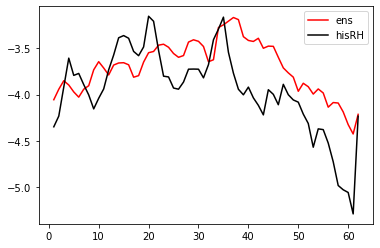

In [4]:
# IPSL
t2mData = xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_tas_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
tLevData = xr.open_dataset('../../../Data/CMIP6/IPSL-CM6A-LR/NDJF/Regrid_NH_ta_NDJFday_IPSL-CM6A-LR_historical_r1i1p1f1_gr_18500101-20141231.nc')
t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

#Calculate inv
inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
rh_ds.attrs
rh_ds.attrs['units']='K'
rh_ds.attrs['long_name']='t850-t2m'

# apply mask
rh_ds.rh.values=rh_ds.rh.values*mask

rhD  = rh_ds.rh.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))

# EC-Earth3
t2mData = xr.open_dataset('../../../Data/CMIP6/EC-Earth3/processed/Regrid_tas_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-20141231.nc')
tLevData = xr.open_dataset('../../../Data/CMIP6/EC-Earth3/processed/Regrid_ta_day_EC-Earth3_historical_r1i1p1f1_gr_18500101-20141231.nc')
t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

#Calculate inv
inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
rh_ds.attrs
rh_ds.attrs['units']='K'
rh_ds.attrs['long_name']='t850-t2m'

# apply mask
rh_ds.rh.values=rh_ds.rh.values*mask
rhD  = rh_ds.rh.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))


# ACCESS-CM2

t2mData = xr.open_dataset('../../../Data/CMIP6/ACCESS-CM2/tasNHRegrid_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
tLevData = xr.open_dataset('../../../Data/CMIP6/ACCESS-CM2/taNHRegrid_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

#Calculate inv
inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
rh_ds.attrs
rh_ds.attrs['units']='K'
rh_ds.attrs['long_name']='t850-t2m'
# apply mask
rh_ds.rh.values=rh_ds.rh.values*mask
rhD  = rh_ds.rh.sel(latitude=slice(32,24),longitude=slice(74,86))
rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
rhTsACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))



MTs=[rhTsIPSL,rhTsEC,rhTsACCESS]

MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensTs=rhTs.copy()
ensTs.values=meanMS


# # Historical Moisture
x=np.arange(1,63)
rhHistMean1=ensTs.groupby('time.dayofyear').mean()
rhHistMean2=rhHistMean1.roll(dayofyear=31)
histRH_ens=rhHistMean2[(rhHistMean2.dayofyear<366) | (rhHistMean2.dayofyear>366)]
plt.plot(x,histRH_ens,label='ens', color='red')
plt.plot(x,histRH,label='hisRH', color='black')

#plt.ylim([275, 295])
plt.legend()



In [5]:
MTs=[rhTsIPSL,rhTsEC,rhTsACCESS]

MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensTs=rhTs.copy()
ensTs.values=meanMS

ensTsMean=ensTs.groupby('time.dayofyear').mean()
ensTsStd=ensTs.groupby('time.dayofyear').std()
ensTsMean


[-4.644472  -4.204983  -4.0332656 ... -4.4842668 -3.9282548 -3.3667128]


<xarray.DataArray 'rh' (dayofyear: 63)>
array([-3.4783864, -3.6436348, -3.6222394, -3.2730489, -3.2435784,
       -3.2041795, -3.1642566, -3.1872182, -3.3719723, -3.4129443,
       -3.423741 , -3.389387 , -3.4975505, -3.4744425, -3.4769242,
       -3.5955443, -3.710326 , -3.7642317, -3.8106747, -3.963584 ,
       -3.87684  , -3.9142644, -3.9939213, -3.9384928, -3.9821615,
       -4.135853 , -4.085917 , -4.091015 , -4.1869273, -4.3246965,
       -4.4263935, -4.2137904, -4.0552535, -3.941619 , -3.8496296,
       -3.8955333, -3.9706166, -4.027256 , -3.9412475, -3.903306 ,
       -3.731145 , -3.643014 , -3.7114778, -3.786863 , -3.679597 ,
       -3.6571429, -3.6540947, -3.6767504, -3.8111994, -3.7942846,
       -3.6473308, -3.5456827, -3.5323048, -3.4640524, -3.4537237,
       -3.4867303, -3.5544472, -3.5955641, -3.576602 , -3.4305937,
       -3.4057882, -3.4224277, -3.7192264], dtype=float32)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

-3.7031048271076954


/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3127: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


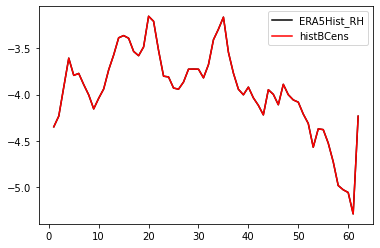

In [22]:
### Historical Bias Correction

x=np.arange(1,63)
plt.plot(x,histRH,label='ERA5Hist_RH', color='black')



MTs=[]
for c in rhTsACCESS.time:
        
    MTs.append((rhTsACCESS.sel(time=c)+rhTsIPSL.sel(time=c)+
                rhTsEC.sel(time=c))/3.0)
    
ensFu=rhTsACCESS.copy()
ensFu.values=MTs


MS=np.array(MTs)
meanMS=np.mean(MS, axis=0)
print(meanMS)

ensFu=rhTsACCESS.copy()
ensFu.values=MTs

ensFuMean=ensFu.groupby('time.dayofyear').mean()
ensFuStd=ensFu.groupby('time.dayofyear').std()

### Change factor

BC=[]


for d in ensFu.time:
    t=pd.Period(d.values, freq='H').dayofyear
    yr=d.dt.year.values
    if(isleap(yr) & t>334 ):
        t=t-1
    
    BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    

#ensFuBC=np.array(BC)

ensFuBC = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
#print(ensFuBC)
#print(ensFu)

#print(ensFuBC)
#print(cnnObs)

ensFuBCHistMean1=ensFuBC.groupby('time.dayofyear').mean()
ensFuBCHistMean2=ensFuBCHistMean1.roll(dayofyear=31)
histBCens=ensFuBCHistMean2[(ensFuBCHistMean2.dayofyear<366) | (ensFuBCHistMean2.dayofyear>366)]
plt.plot(x,histBCens,label='histBCens', color='red')
plt.legend()
plt.savefig('histEnsBCTS.eps')
plt.show()

df=histBCens.to_dataframe(name='histEnsBCTS')
np.savetxt('histEnsInv.txt', df.values, fmt='%1.3f')




# Future proj

In [7]:
## CF Future
ssps=['370','585']
#ssps=['370']

/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3127: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3127: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


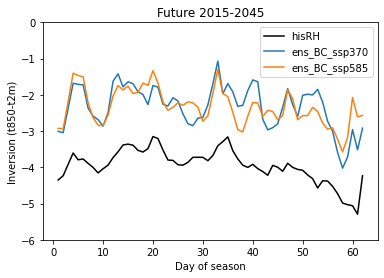

In [21]:
# # Historical Moisture
x=np.arange(1,63)
#plt.plot(x,histRH_ens,label='ens', color='red')
plt.plot(x,histRH,label='hisRH', color='black')


for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    # IPSL
    t2mData = xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData = xr.open_dataset(folderString+'Regrid_ta_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    rh_ds.attrs
    rh_ds.attrs['units']='K'
    rh_ds.attrs['long_name']='t850-t2m'
    # apply mask
    rh_ds.rh.values=rh_ds.rh.values*mask
    rhD  = rh_ds.rh.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    #rhTsIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2045-12-31')))
    
    #EC-Earth3
    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    t2mData = xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData = xr.open_dataset(folderString+'Regrid_ta_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    rh_ds.attrs
    rh_ds.attrs['units']='K'
    rh_ds.attrs['long_name']='t850-t2m'
    # apply mask
    rh_ds.rh.values=rh_ds.rh.values*mask
    rhD  = rh_ds.rh.sel(latitude=slice(32,24),longitude=slice(74,86))
    
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    #rhTsIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2045-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    t2mData = xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    tLevData = xr.open_dataset(folderString+'Regrid_ta_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    rh_ds.attrs
    rh_ds.attrs['units']='K'
    rh_ds.attrs['long_name']='t850-t2m'
    # apply mask
    rh_ds.rh.values=rh_ds.rh.values*mask
    rhD  = rh_ds.rh.sel(latitude=slice(32,24),longitude=slice(74,86))
    
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2015-1-1','2045-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF 
    ensFuBCMean1=ensFuBCF.groupby('time.dayofyear').mean()
    ensFuBCMean2=ensFuBCMean1.roll(dayofyear=31)
    ensFuBCMean=ensFuBCMean2[(ensFuBCMean2.dayofyear<366) | (ensFuBCMean2.dayofyear>366)]

    plt.plot(x,ensFuBCMean,label='ens_BC_ssp'+sp)
    df=ensFuBCMean.to_dataframe(name='ens_future')
    np.savetxt('ens_BC_2015_2045_ssp'+sp+'.txt', df.values, fmt='%1.3f')
    
plt.ylim([-6, 0])
plt.legend()
plt.ylabel('Inversion (t850-t2m)') 
plt.xlabel('Day of season')     
plt.title('Future 2015-2045') 
plt.savefig('Inv_2015_2045.eps')
    

/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3127: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3127: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


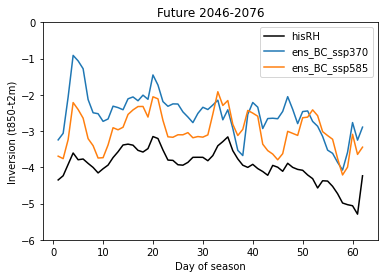

In [23]:
# # Historical Moisture
x=np.arange(1,63)
#plt.plot(x,histRH_ens,label='ens', color='red')
plt.plot(x,histRH,label='hisRH', color='black')


for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    # IPSL
    t2mData = xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData = xr.open_dataset(folderString+'Regrid_ta_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    rh_ds.attrs
    rh_ds.attrs['units']='K'
    rh_ds.attrs['long_name']='t850-t2m'
    # apply mask
    rh_ds.rh.values=rh_ds.rh.values*mask
    rhD  = rh_ds.rh.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    #rhTsIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2046-1-1','2076-12-31')))
    
    #EC-Earth3
    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    t2mData = xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData = xr.open_dataset(folderString+'Regrid_ta_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    rh_ds.attrs
    rh_ds.attrs['units']='K'
    rh_ds.attrs['long_name']='t850-t2m'
    # apply mask
    rh_ds.rh.values=rh_ds.rh.values*mask
    rhD  = rh_ds.rh.sel(latitude=slice(32,24),longitude=slice(74,86))
    
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    #rhTsIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2046-1-1','2076-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    t2mData = xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    tLevData = xr.open_dataset(folderString+'Regrid_ta_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    rh_ds.attrs
    rh_ds.attrs['units']='K'
    rh_ds.attrs['long_name']='t850-t2m'
    # apply mask
    rh_ds.rh.values=rh_ds.rh.values*mask
    rhD  = rh_ds.rh.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2046-1-1','2076-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF 
    ensFuBCMean1=ensFuBCF.groupby('time.dayofyear').mean()
    ensFuBCMean2=ensFuBCMean1.roll(dayofyear=31)
    ensFuBCMean=ensFuBCMean2[(ensFuBCMean2.dayofyear<366) | (ensFuBCMean2.dayofyear>366)]
    df=ensFuBCMean.to_dataframe(name='ens_future')
    np.savetxt('ens_BC_2046_2076_ssp'+sp+'.txt', df.values, fmt='%1.3f')

    plt.plot(x,ensFuBCMean,label='ens_BC_ssp'+sp)
    
plt.ylim([-6, 0])
plt.legend()
plt.ylabel('Inversion (t850-t2m)') 
plt.xlabel('Day of season')     
plt.title('Future 2046-2076') 
plt.savefig('Inv_2046_2076.eps')
    

/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3127: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
/home/cccr/diptih/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:3127: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


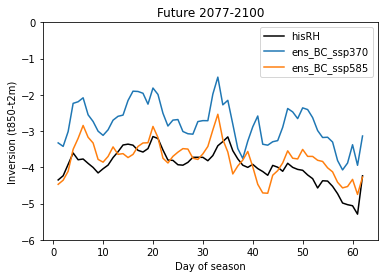

In [24]:
# # Historical Moisture
x=np.arange(1,63)
#plt.plot(x,histRH_ens,label='ens', color='red')
plt.plot(x,histRH,label='hisRH', color='black')


for sp in ssps:

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/IPSL-CM6A-LR/processed/'
    
    # IPSL
    t2mData = xr.open_dataset(folderString+'Regrid_tas_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData = xr.open_dataset(folderString+'Regrid_ta_day_IPSL-CM6A-LR_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    rh_ds.attrs
    rh_ds.attrs['units']='K'
    rh_ds.attrs['long_name']='t850-t2m'
    # apply mask
    rh_ds.rh.values=rh_ds.rh.values*mask
    rhD  = rh_ds.rh.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    #rhTsIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))
    rhTIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2077-1-1','2100-12-31')))
    
    #EC-Earth3
    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/EC-Earth3/processed/'
    t2mData = xr.open_dataset(folderString+'Regrid_tas_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    tLevData = xr.open_dataset(folderString+'Regrid_ta_day_EC-Earth3_ssp'+sp+'_r1i1p1f1_gr_20150101-21001231.nc')
    t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    rh_ds.attrs
    rh_ds.attrs['units']='K'
    rh_ds.attrs['long_name']='t850-t2m'
    # apply mask
    rh_ds.rh.values=rh_ds.rh.values*mask
    rhD  = rh_ds.rh.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    #rhTsIPSL=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('1980-12-1','2014-1-31')))
    rhTEC=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2077-1-1','2100-12-31')))

    folderString='/home/cccr/diptih/dipti/Data/ssp'+sp+'/ACCESS-CM2/processed/'
    t2mData = xr.open_dataset(folderString+'Regrid_tas_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    tLevData = xr.open_dataset(folderString+'Regrid_ta_day_ACCESS-CM2_ssp'+sp+'_r1i1p1f1_gn_20150101-21001231.nc')
    t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
    tLevD = tLevData.sel(latitude=slice(32,24),longitude=slice(74,86))

    #Calculate inv
    inv=tLevD.ta.sel(plev=85000,method='nearest').values-t2mD.tas.values
    rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), inv)}, 
                    coords={'time': t2mD.time,'latitude': t2mD.latitude,'longitude': t2mD.longitude})
    rh_ds.attrs
    rh_ds.attrs['units']='K'
    rh_ds.attrs['long_name']='t850-t2m'
    # apply mask
    rh_ds.rh.values=rh_ds.rh.values*mask
    rhD  = rh_ds.rh.sel(latitude=slice(32,24),longitude=slice(74,86))
    rhTS1=rhD.mean(dim=['latitude','longitude'], skipna=True)
    rhTACCESS=(rhTS1[((rhTS1.time.dt.month>11) | (rhTS1.time.dt.month<2)) ].sel(time=slice('2077-1-1','2100-12-31')))
    
    MTs=[]
    for c in rhTACCESS.time:
        MTs.append((rhTsACCESS.sel(time=c,method="nearest")+rhTIPSL.sel(time=c,method="nearest")+
                rhTEC.sel(time=c,method="nearest"))/3.0)
    
    
    #MS=np.array(MTs)
    #meanMS=np.mean(MS, axis=0)
    #print(meanMS)

    ensFu=rhTACCESS.copy()
    ensFu.values=MTs 
    
    BC=[]

    for d in ensFu.time:
        t=pd.Period(d.values, freq='H').dayofyear
        yr=d.dt.year.values
        if(isleap(yr) & t>334 ):
            t=t-1
    #print(t)
        BC.append(rhERA5HistMean.sel(dayofyear=t).values+
                               (rhERA5HistStd.sel(dayofyear=t).values/ensTsStd.sel(dayofyear=t).values)*
                               (ensFu.sel(time=d).values-ensTsMean.sel(dayofyear=t).values))
    #print(BC)
    ensFuBCF = xr.DataArray( data=BC,dims=[ "time"], coords=dict(time=ensFu.time))
    ensFuBCF 
    ensFuBCMean1=ensFuBCF.groupby('time.dayofyear').mean()
    ensFuBCMean2=ensFuBCMean1.roll(dayofyear=31)
    ensFuBCMean=ensFuBCMean2[(ensFuBCMean2.dayofyear<366) | (ensFuBCMean2.dayofyear>366)]
    df=ensFuBCMean.to_dataframe(name='ens_future')
    np.savetxt('ens_BC_2077_2100_ssp'+sp+'.txt', df.values, fmt='%1.3f')

    plt.plot(x,ensFuBCMean,label='ens_BC_ssp'+sp)
    
plt.ylim([-6, 0])
plt.legend()
plt.ylabel('Inversion (t850-t2m)') 
plt.xlabel('Day of season')     
plt.title('Future 2077-2100') 
plt.savefig('Inv_2077_2100.eps')
    